# Research Project

# Abstract

In this research I will briefly present the concept of the Universal Portfolio, first presented by Thomas Cover in the article of the same name, together with the performance obtained. To better understand Cover's study, I will mention  constant rebalancing portfolios. In the second part of the study, I will present a genetic algorithm for the Knapsack problem, with the aim of showing how this algorithm can achieve results in portfolio management. The Knapsack Problem thus lends itself as a tool for framing the stock picking problem in question. I will use the following R libraries and compare their tools with my own in order to show the advantages and limitations of the strategies used. All the libraries presented are well known for data cleaning and data visualisation, with the only exception of 'logopt', which offers exactly the portfolio strategies presented by Cover.

# Introduction

In [2]:
library(logopt)
library(matrixStats)
library(genalg)
library(ggplot2)
library(dplyr)
library(plotly)

In [3]:
data(nyse.cover.1962.1984)
x <- coredata(nyse.cover.1962.1984)
head(x)

ahp,alcoa,amerb,arco,coke,comme,dow,dupont,espey,exxon,⋯,merck,mmm,mobil,morris,pandg,pills,schlum,sears,sherw,tex
1.01515,1.02765,1.04183,1.02083,1.00637,1.04938,1.00847,1.01983,1.05426,0.99751,⋯,1.03148,1.03377,1.01018,1.01495,1.00775,1.00526,1.01176,1.00578,0.99697,0.99752
1.01493,1.04036,0.98905,0.99490,1.00475,0.95294,1.00840,1.00833,1.04412,1.00500,⋯,1.00898,1.00251,1.01259,1.00000,1.00192,1.00000,1.01938,1.00958,0.99088,1.00248
1.00000,0.97629,0.97786,0.99744,0.98583,0.98765,0.99722,0.99449,0.97183,1.00000,⋯,0.98043,0.95990,0.99751,0.97218,0.98656,0.98429,0.97338,1.00000,1.02761,0.99752
1.02451,1.00662,1.02642,1.00257,1.01917,1.00000,0.99443,1.00693,1.00000,1.00000,⋯,1.01089,1.03655,1.01247,0.99663,1.00778,1.01596,1.00000,1.00190,1.00299,1.02233
1.03100,0.98465,1.00368,1.00513,1.00313,1.05000,1.02801,1.00413,1.05797,1.01741,⋯,1.01077,0.99496,0.99507,0.98649,1.01158,0.99738,1.01563,1.01515,1.01190,1.00971
1.00465,1.01559,0.98901,1.01020,1.00625,0.96429,0.99455,0.99863,0.98630,1.01222,⋯,0.99645,1.01266,1.00495,1.00514,1.01908,0.98688,1.01154,0.99067,0.97647,1.00240


Suppose a gambler has an initial bankroll of $X_0$ and bets at each time step $t$ a given fraction $f$ of  $X_t$. Should he win, he would get  $f X_t$ back and another $f X_t$, however a loss would shriken his bankroll  $f X_t$. The bankroll would then evolve as 
$$
X_n=X_0(1+f)^S(1-f)^F
$$
where $S$ is the number of successes and $F$ the number of failures, i.e., in particular $S+F=n$. The gambler would obtain a average growth (per bet) of
$$
\left(\frac{X_n}{X_0}\right)^{1 / n}=(1+f)^{S / n}(1-f)^{F / n}
$$


where $S / n \rightarrow p$ the probability of success and $F / n \rightarrow 1-p$ the probability of failure. The term on the left is the growth rate per bet on average and the gambler wants to find an $f$ that maximizes this quantity via the right-hand side. Taking the logs leads to 
$$
\frac{1}{n}\left(\log X_n-\log X_0\right)=\frac{S}{n} \log (1+f)+\frac{F}{n} \log (1-f),
$$
or in the limit for $n$ large we obtain:

\begin{equation}
    \mathbb{E}[g(f)]=p \log (1+f)+(1-p) \log (1-f)\label{maxExpLog}
\end{equation}


where $g$ is the expected growth rate per bet when betting fraction $f$, which is independent of $n$ now. We can now apply this framework to investing decisions, since the payoff of each decision can differ significantly and the probability of success is not easily available. Suppose we have $n$ assets, with random return vector $x \in \mathbb{R}^n$, where the $x_i$ are of the form $x_i=\frac{p_i(\text { new) }}{p_i \text { (old) }}$, i.e., relative price changes. In the spirit of Kelly's approach, we allocate fractions across these assets, so that the logarithmic growth rate is given as $\log f^{\top} x$. 

$$
f \in \Delta(n) \doteq\left\{f \in \mathbb{R}^n \mid \sum_i f_i=1, f \geq 0\right\}
$$

Thus, We would have the relative price change realizations $x_t$ in time $t$ and allocations $f_t$, so that the logarithmic portfolio growth over time is given by
$$
\sum_{t=1}^T \log f_t^T x_t
$$

Equivalently the average logarithmic growth rate is given by:

\begin{equation}
    \frac{1}{T} \sum_{t=1}^T \log f_t^T x_t\label{avgLogGrowth}
\end{equation}

which is the generalization of (1), however now we spread capital along multiple assets.

## Constant Rebalancing Portfolio

A Constant Rebalancing Portfolio (CRP) is one where the $f_t=f$ are constant over time with the implicit assumption(!!) that the return distribution is somewhat stationary and hence from a sequential decision perspective we maximize the expected logarithmic growth rate by picking the expectation maximizer in each step assuming(!!) i.i.d. returns. The term constant rebalancing arises from the fact that in each time step, we rebalance the portfolio to represent the constant allocation $f$ across assets; note that this rebalancing usually incurs transaction costs.


One of the arguments for CRPs is that they can even generate a return when the log geometric mean of the random variable we are investing in is 0, e.g., a fair coin whose payout is so that we have a new bankroll of amount $1+r$ when $X=1$ and $1 /(1+r)$ if $X=0$. More generally, suppose that we have a discrete one dimensional random variable $1+X$ (this is our bet) with outcomes $1+x_i \in \mathbb{R}_{+}$with probability $p_i$, i.e., the $x_i$ corresponding to the returns, so that the log geometric mean is at least 0 :

$$
\sum_i p_i \log \left(1+x_i\right) \geq 0
$$
Betting a fraction $f$ leads to the expected growth function:
$$
r(f) \doteq \sum_i p_i \log \left(1+f x_i\right)
$$
Observe that $r(f)$ is strictly concave in $f$ in the interval $f \in[0,1]$ with $r(0)=0$ and $r(1) \geq 0$ (here we use that the log geometric mean is at least 0 ). Thus by concavity (or Jensen's inequality) it follows:
$$
r(f)=r(1 \cdot f+0 \cdot(1-f))>f \cdot r(1)+(1-f) \cdot r(0) \geq 0 .
$$
As such betting a fraction of $f=1 / 2$ is always safe as long as the geometric mean is at least 1. However, for completeness, note that betting a fixed fraction of $1 / 2$ can be quite suboptimal.


# Universal Portfolios

Cover showed that the best CRP provides returns at least as good as buying and holding any particular stock, as his portfolios yield the average of the returns all stocks. Once the notion of Constant Rebalancing Portfolios is defined, given a set of assets, a natural question is whether one can estimate or compute the optimal allocation vector $f$ given either distributional assumptions about the returns or actual data. The natural second order question is then, if so, whether it is possible while investing. Given relative price change vectors $x_1, \ldots, x_T$, we want to solve:
$$
\max _{f \in \mathbb{R}^n} \frac{1}{T} \sum_{t=1}^T \log f^T x_t  %\label{staticLogOpt}
$$
While this optimization problem can easily be solved with convex optimization methods, provided the price change vectors $x_1, \ldots, x_T$, this is not very helpful as the past is usually not a great predictor for the future. Motivated by the strong connection to information theory, Cover realized that one can define Universal Portfolios, that are growth optimal for unknown returns for universal coding where an asymptotically optimal code can be constructed without knowing the source's statistics. The algorithm constructs a portfolio over time, so that when $T \rightarrow \infty$, for any sequence of relative price changes $x_1, \ldots, x_T$, then
$$
\frac{1}{T} \sum_{t=1}^T \log f_t^T x_t \rightarrow \max _{f \in \mathbb{R}^n} \frac{1}{T} \sum_{t=1}^T \log f^T x_t  %\label{universalPortfolio}
$$
where the $f_t$ are dynamic allocations. However, the proposed algorithm spreads the capital across an exponential number of sequences arising from binary strings of length $T$ (assuming the most basic case based on a binomial model), making it impractical for computational implementation as well as from an actual real-world perspective as one would probably be bankrupted by transaction costs (nonetheless, it has been developed a theoretically polynomial time implementable variant of Cover's universal portfolios).

The Universal Portfolios approximate the return of optimal fixed portfolio in the long term. Formally, with $m$ stocks, let $\mathbf{x}_i=\left(x_{i, 1}, \ldots, x_{i,m}\right)^T \in \mathbb{R}^m$ be the vector of stock return in day $i$. Note that on day $i$ when we decide our portfolio, we only know the price of previous days, instead of $\mathbf{x}_i$. Here $x_{i, j}$ is the return of stock $j$ in day $i$, i.e. $x_{i, j}=\frac{\text { price of stock } j \text { on day } i}{\text { price of stock } j \text {on day } i-1}$. On each day $i$, we use a vector $\mathbf{f}_i=\left(f_{i, 1}, \ldots, f_{i, m}\right)^T \in \Delta^m$ to represent the portfolio. Here $\Delta^m$ is the simplex $\left\{\mathbf{f} \in \mathbb{R}^m \mid \sum_{j=1}^m f_j=1\right\}$. On day $i$ we allocate $f_{i, j}$ of our current total wealth to stock $j$. Thus our return on day $i$ is $\mathbf{f}_i^T \mathbf{x}_i$, compared with day $i-1$. The total return after $n$ days is $T_n=\prod_{i=1}^n \mathbf{f}_i^T \mathbf{x}_i$.
With Universal Portfolios, we can approximate the return of optimal Constant Rebalancing Portfolio, as we defined it as a fixed wealth allocation throughout all days. Given a fixed wealth allocation $\mathbf{f} \in \Delta^m$, the return of CRP on day $n$ is $S_n(\mathbf{f})=\prod_{i=1}^n \mathbf{f}^T \mathbf{x}_i$. With Universal Portfolio algorithm, we can achieve
$$
\frac{T_n}{S_n\left(\mathbf{f}^*\right)} \geq \frac{1}{(n+1)^{m-1}}
$$
Here $\mathbf{f}^*$ is the optimal CRP. Considering the average return per day, we have
$$
\left(\frac{T_n}{S_n\left(\mathbf{f}^*\right)}\right)^{\frac{1}{n}} \geq \frac{1}{(n+1)^{\frac{m-1}{n}}}
$$
As $n \rightarrow \infty$, the right hand side approach 1 . Thus we get an average daily return comparable with optimal CRP. However, it has been shown that, in a market with $m$ stocks, over $n$ days,
$$
\frac{\text{performance of UNIVERSAL }}{\text{ performance of best CRP }} \geq \frac{1}{(n+1)^{m-1}}
$$

By performance, we mean the return per dollar on an investment. The above ratio is a decreasing function of $n$. However, the average per-day ratio, $\left(1 /(n+1)^{m-1}\right)^{1 / n}$, increases to 1 as $n$ increases without bound. For example, if the best CRP makes 1.5 times as much as we do each day over a period of 22 years, it is only making a factor of $1.5^{1 / 22} \approx 1.02$ as much as we do per year. Such implementations of Cover's algorithm are exponential in the number of stocks with worst-case run times of $\Theta\left(n^{m-1}\right)$. In some sense, Cover's algorithm divides its money evenly among all CRPs. Unfortunately, for some market sequences, the number of CRPs which perform near optimally can be as small as $1 / \Theta\left(n^{m-1}\right)$.



# Conclusions

## Essentials

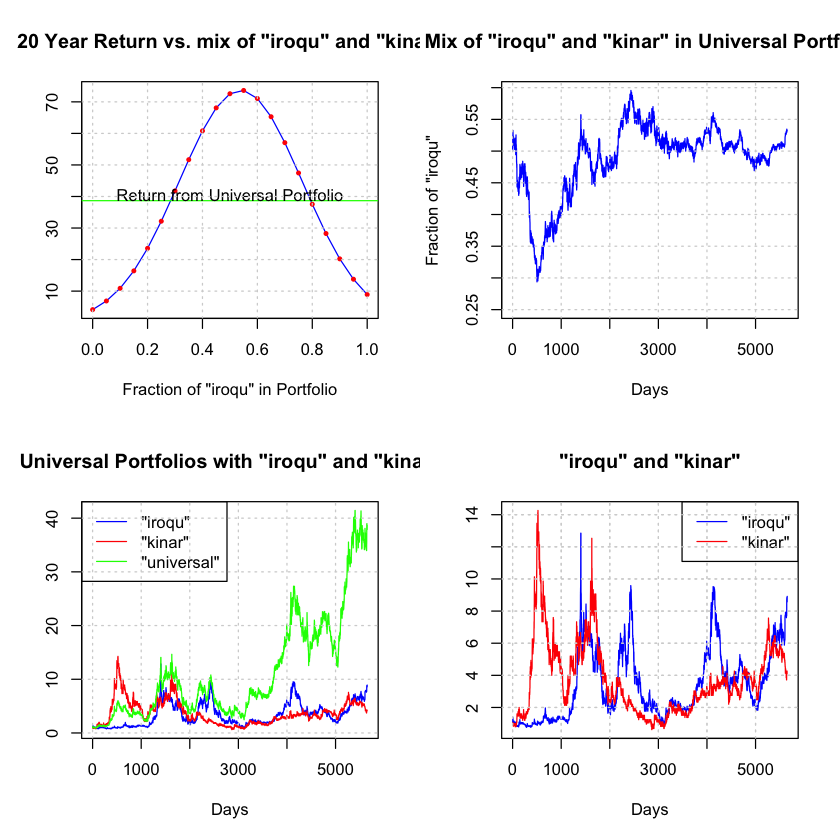

In [4]:
wrap_graphs <- function(){
  
  xik <- x[,c("iroqu","kinar")]
  nDays <- dim(xik)[1]
  Days <- 1:nDays
  alphas <- seq(0,1,by=0.05)
  crps <- alphas
  for (i in 1:length(crps)) {
    crps[i] <- crp(xik, c(alphas[i], 1-alphas[i]))[nDays]
  }
  
  
  
  pik <- apply(xik,2,cumprod)
  alphas <- seq(0,1,by=0.05)
  universal <- xik[,1] * 0
  for (i in 1:length(alphas)) {
    universal <- universal + crp(xik, c(alphas[i], 1-alphas[i]))
  }
  
  
  universal <- universal/length(alphas)
  
  
  par(mfrow = c(2,2))
  
  plot(alphas, crps, col="blue", type="l", ylab="", 
       main='20 Year Return vs. mix of "iroqu" and "kinar"',
       xlab='Fraction of "iroqu" in Portfolio')
  points(alphas, crps, pch=19, cex=0.5, col="red")
  abline(h=mean(crps), col="green")
  text(0.5,mean(crps)*1.05,labels="Return from Universal Portfolio")
  grid()
  bk <- xik[,1] * 0
  w <- xik[,1] * 0
  for (i in 1:length(crps)) {
    # we calculate bk by weighting the b by the realized wealth lagged one
    weight <- lag(crp(xik, c(alphas[i], 1-alphas[i])), 1)
    bk <- bk + alphas[i] * weight
    w <- w + weight
  }
  bk <- bk / w
  bk[1] <- 0.5
  plot(Days, bk, col="blue", type="l", ylim = range(0.25, range(bk)), 
       main = 'Mix of "iroqu" and "kinar" in Universal Portfolio', 
       ylab='Fraction of "iroqu"')
  grid()
  
  
  
  plot(Days, pik[,"iroqu"], col="blue", type="l", ylim=range(pik, universal), 
       main = 'Universal Portfolios with "iroqu" and "kinar"', ylab="")
  
  lines(Days, pik[,"kinar"], col="red")
  lines(Days, universal, col="green")
  legend("topleft",c('"iroqu"','"kinar"','"universal"'),
         col=c("blue","red","green"),lty=c(1,1,1))
  
  grid()
  
  plot(Days, pik[,"iroqu"], col="blue", type="l", 
       ylim=range(pik), main = '"iroqu" and "kinar"', ylab="")
  lines(Days, pik[,"kinar"], col="red")
  grid()
  legend("topright",c('"iroqu"','"kinar"'),
         col=c("blue","red"),lty=c(1,1))
  grid()
  
  
  
}
wrap_graphs()

As we can see in the example proposed by this portfolio, the Universal Portfolio is able to guarantee the average of possible portfolios. This means that the more portfolios are considered, the closer the performance of the Universal Portfolio will be to that of the best portfolio. This result is repeated for any combination from the dataset considered in the Cover paper.

In [5]:
my.crp <- function(df=x,
                   days=DAYS,
                   vector=NULL,
                   rebalance=T,
                   how_far_back=HOW_FAR_BACK, #how far back
                   reb_freq=HOW_OFTEN       #how often do you want to rebalance?
){
  
  if(is.null(vector)){
    w = rep(1, dim(df)[2]) / dim(df)[2]
  }else{
    w=vector}
  
  W <- matrix(w,byrow=T,ncol=dim(df)[2])
  colnames(W) <- colnames(df)
  
  S <- 1
  
  for(i in 1:days){
    S <- c(S, w%*%df[i,]*tail(S,1))
    
    if(rebalance){
      
      if(i%%reb_freq==0){
        if(how_far_back==1){
          if(i>1){
            w<- colProds(df[(i-how_far_back):i,])/sum(colProds(df[(i-how_far_back):i,]))
          }
        }else{
          
          w<- colProds(df[(i-how_far_back):i,])/sum(colProds(df[(i-how_far_back):i,]))   
        }
        
        
      }
      
      
      
      
    }
    
    W <- rbind(W,w)
  }
  
  row.names(W) <- NULL
  
  #DF <- df[1:days,]
  #CPR <- S[2:(days+1)]
  #DF <- cbind(df[1:days,],CPR)
  #results <- list(S, W, DF)
  #print(tail(S,1))
  
  return(S)
}

DAYS= dim(x)[1]
HOW_OFTEN = 11
HOW_FAR_BACK = 10
df = x[,c('iroqu','kinar')]

tail(my.crp(df),1)

[1] 52.33791

In [6]:
#Constant Rebalanced Portfolio ALL THE WAY BACK 
crp.ATWB <- function(df=x,
                     days=DAYS,
                     vector=NULL,
                     rebalance=T,
                     reb_freq=HOW_OFTEN   #how often do you want to rebalance?
){
  
  if(is.null(vector)){
    w = rep(1, dim(df)[2]) / dim(df)[2]
  }else{
    w=vector}
  
  W <- matrix(w,byrow=T,ncol=dim(df)[2])
  colnames(W) <- colnames(df)
  
  S <- 1
  
  for(i in 1:days){
    S <- c(S, w%*%df[i,]*tail(S,1))
    
    if(rebalance){
      
      if(i%%reb_freq==0){
        if(i>1){
          w<- colProds(df[1:i,])/sum(colProds(df[1:i,]))
        }
        
        
      }
      
      
    }
    
    W <- rbind(W,w)
  }
  
  row.names(W) <- NULL
  
  #DF <- df[1:days,]
  #CPR <- S[2:(days+1)]
  #DF <- cbind(df[1:days,],CPR)
  #results <- list(S, W, DF)
  #print(tail(S,1))
  
  return(S)
}

DAYS= dim(x)[1]
HOW_OFTEN = 11
df = x[,c('iroqu','kinar')]

tail(crp.ATWB(df),1)

[1] 22.37395

In [ ]:
DAYS= dim(x)[1]
x_ <- c(2,seq(10, 80, 10))
df=x[,c('iroqu','kinar')]

h1 <- c() #how often /frequency
h2 <- c() #how far back
z <- c()

for(i in x_){
  for(j in x_){
    if(i>=j){
      h1 <- c(h1,i)
      h2 <- c(h2,j)
      z <- c(z, tail(my.crp(df,reb_freq=i,how_far_back=j),1))
      
    }
  }

}

data <- data.frame(x1=h1, x2=h2, z=z)

#https://plotly.com/python/builtin-colorscales/
plot_ly(data, x = ~x1, y = ~x2, z = ~z,
        marker = list(color = ~z, showscale = TRUE,colorscale='Plasma')) %>%
  add_markers() %>% 
  layout(scene = list(xaxis = list(title = 'Frequency to rebalance'),
                      yaxis = list(title = 'Time Window'),
                      zaxis = list(title = 'Portfolio Value')),
         annotations = list(x=1,y=1,
                            text='Portfolio Value',
                            xref='paper',
                            yref='paper',
                            showarrow=FALSE))



The following graphs show that these variables do not necessarily give a lower result than those observed by Cover, so one would have to find the optimal level of both variables to maximise one's performance. it is therefore necessary to frame the problem to try to solve these unknowns. Moreover, a further limitation of Cover is the limited number of shares that are drawn, and how it does not rebalance to exclude the worst ones by replacing them with better performing ones.

In [ ]:
s <- my.crp(df=x[,c('iroqu','kinar')],
       days=dim(x)[1],
       how_far_back = 1,
       reb_freq = 10)


u20<- universal.cover(x[,c('iroqu','kinar')],n=20)
u2000 <- universal.cover(x[,c('iroqu','kinar')],n=2000)

df <- data.frame(x=0:dim(x)[1], u20=c(1,u20),
                                      u2000=c(1,u2000),
                                      crp10=s)


ggplot(df, aes(x=x)) +
  geom_line(aes(y = u20,colour='Universal Portfolio n 20')) +
  geom_line(aes(y = u2000,colour='Universal Portoflio n 2000')) +
  geom_line(aes(y = crp10,colour='CRP 10')) +
  scale_color_manual(name = "Portfolios", values = c("CRP 10" = "darkred","Universal Portfolio n 20" = "steelblue",'Universal Portoflio n 2000' ='blue')) +
  ggtitle("First Comparison of UPs' Performance") +
  labs(y = "Portfolio's Value", x = "Days")

In order to highlight the limitations of such portfolios, I refined the notion of a constant rebalancing portfolio so as to consider two additional variables as inputs: the frequency with which the weights of the securities in the portfolio are rebalanced and the length of the time series within which the performance of the securities is considered. In other words, the frequency and length of portfolio rebalancing. This shows the possibility of outperforming the Universal Portfolios.

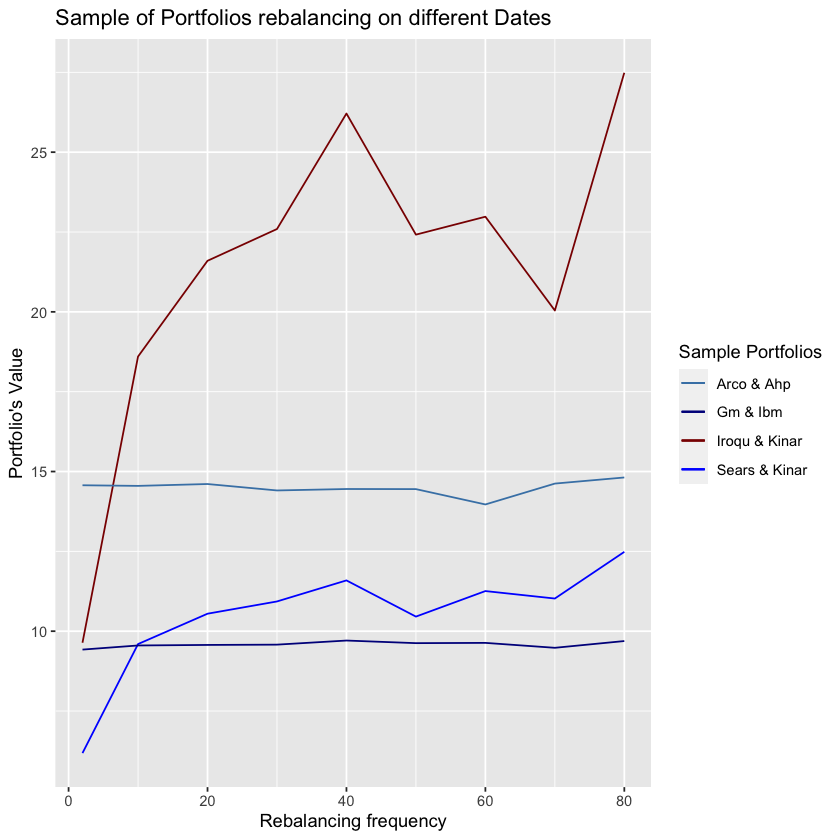

In [12]:
set.seed(1)
DAYS= dim(x)[1]
df = x[,c('iroqu','kinar')]
df1 <- x[,sample(colnames(x),2)]
df2 <- x[,sample(colnames(x),2)]
df3 <- x[,sample(colnames(x),2)]


x_ <- c(2,seq(10, 80, 10))
y <- c()
y1 <- c()
y2 <- c()
y3 <- c()

for(i in x_){
  y <- c(y, tail(crp.ATWB(df,reb_freq=i),1))
  y1 <- c(y1, tail(crp.ATWB(df1,reb_freq=i),1))
  y2 <- c(y2, tail(crp.ATWB(df2,reb_freq=i),1))
  y3 <- c(y3, tail(crp.ATWB(df3,reb_freq=i),1))
}

data.ATWB <- data.frame(x=x_, y=y)
ggplot(data.ATWB, aes(x=x_)) +
  geom_line(aes(y = y,colour='Iroqu & Kinar')) +
  geom_line(aes(y = y1,colour='Arco & Ahp')) +
  geom_line(aes(y = y2,colour='Sears & Kinar')) +
  geom_line(aes(y = y3,colour='Gm & Ibm')) +
  scale_color_manual(name = "Sample Portfolios", values = c("Iroqu & Kinar" = "darkred",
                                                            "Arco & Ahp" = "steelblue",
                                                            'Sears & Kinar' ='blue',
                                                            'Gm & Ibm'='darkblue')) +
  
  ggtitle("Sample of Portfolios rebalancing on different Dates") +
  labs(y = "Portfolio's Value", x = "Rebalancing frequency")

# 

# Implementing a GA for portfolio management

A genetic algorithm is a heuristic optimization technique that can be applied to the Knapsack problem, which involves finding the combination of items that maximizes the total value while staying under a certain weight limit. The algorithm begins by creating an initial population of candidate solutions, which are evaluated using a fitness function that ensures the weight limit is not exceeded. The fittest individuals are selected to generate the next generation of candidate solutions using crossover and mutation operators. The process continues until a termination criterion is met, and the fittest individual in the final population is chosen as the optimal solution to the Knapsack problem.

In [11]:
min_weight <- function(DF){
  v <- c()
  for(i in 1:dim(DF)[2]){
    v <- c(v,sd(DF[,i]))
  }
  return(v)
}
format_sol <- function(x){
  v <- strsplit(strsplit(strsplit(x, ":")[[1]][2],'\n')[[1]][1],' ')
  v <- sapply(v, as.numeric)
  v <- v[!is.na(v)]
  return(v)
}


In this case, I applied a Genetic Algorithm to portfolio management replacing the weight of each stock with its own volatility, while the "value" of the stock is defined by the same price. Moreover, I have supported several attempts, every time changing the parameters (rebalancing frequency and temporal window within which to consider the performances of the actions). In each attempt, the portfolio built by the algorithm proved to be at least as good as the best randomly selected portfolios. This result must also take account of the fact that the GA was subject to an additional degree of freedom, as it also had to choose the actions. 

In [12]:
WEIGHT_LIMIT = 1

DAYS=1000#dim(x)[1]
HOW_OFTEN=80
HOW_FAR_BACK=60


ga.p <- function(dataframe=x,
                 df=x,
                 days=DAYS,
                 reb_freq=HOW_OFTEN,
                 how_far_back=HOW_FAR_BACK,
                 weightlimit=WEIGHT_LIMIT){
  
  fitness <- function(x) {
    current_solution_survivalpoints <- x %*% dataset$survivalpoints
    current_solution_weight <- x %*% dataset$weight
    
    if (current_solution_weight > weightlimit) 
      return(0) else return(-current_solution_survivalpoints)
  }
  
  NEW = c(paste(colnames(df),collapse=', '))
  
  w = rep(1, dim(df)[2]) / dim(df)[2]
  
  
  weightlimit <- WEIGHT_LIMIT#.03
  S <- 1
  time.df <- data.frame()
  
  for(i in 1:days){
    S <- c(S, w%*%df[i,]*tail(S,1))
    
    
    if(i%%reb_freq==0){
      print(i)
      dataset <- data.frame(item=colnames(dataframe),
                            survivalpoints = colProds(dataframe[(i-how_far_back):i,]),
                            weight= min_weight(dataframe[(i-how_far_back):i,]))
      
      
      GAmodel <- rbga.bin(size = dim(dataframe)[2], popSize = 200, iters = 100, mutationChance = 0.05, 
                          elitism = T, evalFunc = fitness)
      
      solution <- format_sol(summary(GAmodel, echo=FALSE))      
      
      if(sum(solution)>=2){
        df <- dataframe[,dataset[solution == 1, ]$item]
        w<- colProds(df[(i-how_far_back):i,])/sum(colProds(df[(i-how_far_back):i,]))
        
        
        
      }else{
        w<- colProds(df[(i-how_far_back):i,])/sum(colProds(df[(i-how_far_back):i,]))
        #P <- rbind(P, colnames(sol_dataframe))
        #W <- rbind(W, w)
      }
      #print(i)
      #print(tail(S,1))
      #print('===========================')
      #print('')
      print(colnames(df))
    }
    if(i>1){
      w<- colProds(df[(i-1):i,])/sum(colProds(df[(i-1):i,]))
    }
    
    NEW <- c(NEW,paste(colnames(df),collapse=', '))
    #print(colnames(df))
    #print(w)
  }
  DF <- data.frame(portfolio=S,stocks_in=NEW)
  return(DF)
  #print(length(NEW))
  #print(length(S))
}



In [ ]:

DAYS=200
HOW_OFTEN=20
HOW_FAR_BACK=14


x_ <- c(.001,seq(.005, .2, .025))
y <- c()

for(i in x_){
  WEIGHT_LIMIT = i
  gap <- tail(ga.p(df=x[,c('ahp', 'arco', 'kinar', 'kodak', 'merck')])$portfolio,1)
  y <- c(y, gap)
}


data <- data.frame(x=x_, y=y)

ggplot(data, aes(x=x)) + 
  geom_line(aes(y = y), color = "darkred") +
  ggtitle("Best Weight Limit") +
  labs(y = "Portfolio's Value", x = "weight limit for GA")

At this point you can see how a portfolio built by a GA is able to produce a return at least comparable with the best achievable portfolios, however this does not justify how the knapsack problem is an extremely simplified interpretation. In fact, if the weight limit were raised, the GA would not hesitate to consider all 36 shares in the dataset as a single portfolio. This is due to the fact that the same weight limit is deliberately defined in a primitive way, as the sum of all the volatilities of the shares within the portfolio. However, this should be an incentive to redefine a more sophisticated version of the problem, so that the GA itself would be able to make a tighter selection and thus lead to a higher portfolio return.

In [ ]:

WEIGHT_LIMIT = .005
DAYS=200 
HOW_OFTEN=10
HOW_FAR_BACK=3


vs_u1 <- ga.p(df=x[,c('ahp', 'arco', 'kinar', 'kodak', 'merck')])
tail(vs_u1$portfolio)




u1 <- universal.cover(x[1:DAYS,c('ahp', 'arco', 'kinar', 'kodak', 'merck')],n=21)
u2 <- universal.cover(x[1:DAYS,c('jnj', 'pills', 'sherw')],n=21)
u3 <- universal.cover(x[1:DAYS,c("gm","iroqu")],n=21)
u4 <- universal.cover(x[1:DAYS,c("gm","tex")],n=21)

test <- x[1:DAYS,sample(1:dim(x)[2],5)]
test1 <- x[1:DAYS,sample(1:dim(x)[2],5)]
test2 <- x[1:DAYS,sample(1:dim(x)[2],5)]
ut <- universal.cover(test,n=21)
ut1 <- universal.cover(test1,n=21)
ut2 <- universal.cover(test2,n=21)

data <- data.frame(day=0:DAYS,
                   ga=vs_u1$portfolio,
                   u1=c(1,u1),
                   u2=c(1,u2),
                   ut=c(1,ut),
                   ut1=c(1,ut1),
                   ut2=c(1,ut2),
                   u3_=c(1,u3_),
                   u4_=c(1,u4_))

ggplot(data, aes(x=day)) + 
  geom_line(aes(y = ga), color = "darkred") + 
  geom_line(aes(y = u1), color="blue", linetype="twodash")+
  geom_line(aes(y = u2), color="steelblue", linetype="twodash")+
  geom_line(aes(y = ut), color="darkblue", linetype="twodash")+
  geom_line(aes(y = ut1), color="lightblue", linetype="twodash")+
  geom_line(aes(y = ut2), color="purple", linetype="twodash")+
  geom_line(aes(y = u3_), color="orange", linetype="longdash")+
  geom_line(aes(y = u4_), color="orange", linetype="longdash") +
  ggtitle("Comparison of Performances") +
  labs(y = "Portfolios ", x = "Days")


